# NLP on Slack

In [24]:
# Definitions for text cleaning


def remove_URL(text):
    cleaned = re.sub(
        r"(https?|ftp)(:\/\/[-_\.!~*\'()a-zA-Z0-9;\/?:\@&=\+\$,%#]+)", "", str(text))
    return cleaned


def remove_bracket(text):
    cleaned = re.sub("(?<=【).*?(?=】)", "", str(text))
    return cleaned


def remove_bracket2(text):
    cleaned = re.sub("(?<=\<).*?(?=\>)", "", str(text))
    return cleaned


def remove_bracket3(text):
    cleaned = re.sub("(?<=\{).*?(?=\})", "", str(text))
    return cleaned


def remove_emoji(text):
    cleaned = re.sub("(?<=:).*?(?=:)", "", str(text))
    return cleaned


def normalize_number(text):
    replaced_text = re.sub(r'\d+', '0', text)
    return replaced_text


def remove_space(text):
    replaced_text = re.sub(r'\s+', '', text)
    return replaced_text


def normal_char_pickup(text):
    cleaned = re.findall('[ーあ-んア-ン一-鿐\s]', text)
    return cleaned


def text_cleaning(text):
    tmp = remove_URL(text)
    tmp = remove_bracket(tmp)
    tmp = remove_bracket2(tmp)
    tmp = remove_emoji(tmp)
    tmp = normalize_number(tmp)
    tmp = normal_char_pickup(tmp)
    tmp = ','.join(tmp)
    tmp = remove_space(tmp)
    cleaned = tmp.replace(",", "")
    return cleaned

## [Task 0] Tips

<br />

There are many kinds of useful libraries for NLP except for Janome. For example,

<br />

- Mecab http://taku910.github.io/mecab/


- chariot https://github.com/chakki-works/chariot


- nltk https://www.nltk.org/


- StanfordNLP https://stanfordnlp.github.io/stanfordnlp/installation_download.html#human-languages-supported-by-stanfordnlp


- Ginza https://megagonlabs.github.io/ginza/

## [Task 1] Review NLP

<br />

I am going to use the following files to analyze contents on Slack.

1. 2019-01-ai.json: Data of a history of messages on a channel named "2019-01-ai" on my Slack


2. random.json: Data of a history of messages on a channel named "random" on my Slack


3. global.json: Data of a history of messages on a channel named "global" on my Slack


4. users_dict.json: Users' ID: Names of users


5. emoji.json: Names of emojis: URL of emojis

In [65]:
import collections
import json
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from janome.tokenizer import Tokenizer
from scipy.sparse.linalg import norm
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

In [22]:
# Load files

path = "slack_data/"
files = ["2019-01-ai", "emoji", "global", "random", "users_dict"]

dic_list = []
for file in files:
    # Open
    f = open(path + file + ".json", "r")
    # Load a JSON file and transform it to a dictionary
    dic = json.load(f)
    # Close
    f.close()
    # Append
    dic_list.append(dic)
    # Check keys of the dictionary
    print(dic.keys())

# Get the files one by one
ai = dic_list[0]
emoji = dic_list[1]
global_ = dic_list[2]
random = dic_list[3]
users = dic_list[4]

dict_keys(['ok', 'messages', 'has_more', 'is_limited'])
dict_keys(['ok', 'emoji', 'cache_ts'])
dict_keys(['ok', 'messages', 'has_more', 'is_limited'])
dict_keys(['ok', 'messages', 'has_more', 'is_limited'])
dict_keys(['U0CGPM9T2', 'U5WEHDZRC', 'U71KZN0HL', 'U7MLFT82K', 'U9SL33S1M', 'UCFCLSRCK', 'UEG9UR1AM', 'UEHD8A6H3', 'UEJ7TBV0R', 'UEJA5HS3G', 'UEVMB7YDN', 'UF1A4QA10', 'UF1KE2X8B', 'UG0P51PNC'])


In [32]:
# Focus on the "messages" and the "emoji"

messages_ai = ai["messages"]
messages_global = global_["messages"]
messages_random = random["messages"]

emojis = emoji["emoji"]

In [33]:
# Check the contents

messages_ai[0]

{'client_msg_id': '6f87c23f-cead-4eb0-b814-89adc7173025',
 'type': 'message',
 'text': '腹痛のため遅れます。',
 'user': 'UEG9UR1AM',
 'ts': '1554425975.002100',
 'reactions': [{'name': 'annoying_dog', 'users': ['U9SL33S1M'], 'count': 1}]}

In [37]:
messages_global[0]

{'user': 'UHNEF4ZEZ',
 'type': 'message',
 'subtype': 'channel_join',
 'ts': '1554367090.000200',
 'text': '<@UHNEF4ZEZ> has joined the channel'}

In [39]:
messages_random[1]

{'client_msg_id': '180df26d-49ff-4eaf-ba4b-4341008fd8e9',
 'type': 'message',
 'text': '<!channel>\n受講生の皆さん、こんにちは！\nDIVE INTO CODEのCMOの丸田です。\n\n【Facebookシェアのお願い】本日、DIVE INTO CODEのFacebookで、DEMODAY 6thのご登壇者の＊田中元基さん＊をご紹介しました！＊ぜひ応援の気持ちを込めて、投稿のチェックやシェアをしていただけると嬉しいです＊ :blush:\nどうぞよろしくお願い致します。\n\n<https://www.facebook.com/diveintocode.jp/posts/1323804734424646>',
 'user': 'UGJTSGW1H',
 'ts': '1554359771.037900',
 'attachments': [{'title': 'DIVE INTO CODE',
   'title_link': 'https://www.facebook.com/diveintocode.jp/posts/1323804734424646',
   'text': '【DEMODAY6th ご登壇者様のご紹介！】4/7のDEMODAY6thもいよいよ目前！本日はご登壇者の田中元基さんをご紹介します。 DIVE INTO...',
   'fallback': 'DIVE INTO CODE',
   'image_url': 'https://scontent-iad3-1.xx.fbcdn.net/v/t1.0-9/56760725_1323804164424703_914698635273306112_o.png?_nc_cat=111&_nc_ht=scontent-iad3-1.xx&oh=86086eeb4b6f5bd26bc3a534296b81fb&oe=5D0466B8',
   'from_url': 'https://www.facebook.com/diveintocode.jp/posts/1323804734424646',
   'image_width': 515,
   'image_height': 250,
  

In [42]:
emojis.keys()

dict_keys(['bowtie', 'squirrel', 'glitch_crab', 'piggy', 'cubimal_chick', 'dusty_stick', 'slack', 'pride', 'thumbsup_all', 'slack_call', 'shipit', 'white_square', 'black_square', 'simple_smile', 'neckbeard', 'metal', 'fu', 'feelsgood', 'finnadie', 'goberserk', 'godmode', 'hurtrealbad', 'rage1', 'rage2', 'rage3', 'rage4', 'suspect', 'trollface', 'octocat', 'beryl', 'rube', 'troll', 'hituji', 'haisyo', 'pikachu1', 'akan', 'pikachu2', 'koduck', 'purin', 'fushigidane', 'hitokage', 'zenigame', 'koiking_to_gyarados', 'inu', 'annoying_dog', 'yattane', 'oo', 'suteki', 'jyuyou', 'nice', 'me', 'hi', 'funasshi', 'goya', 'diveintocode', 'gosurf', 'doki', 'miffy', 'miffy1', 'miffy2', 'cookie1', 'arukuma', 'arukuma2', 'arukuma3', 'arukuma4', 'luffy', 'sasugassu', 'teruteru', 'shiba-ta', 'tommy', 'ichipankun', 'complete', 'amuro', 'noro', 'hiyachu', 'observer', 'hulk', 'skype_bow', 'slime', 'kaggle_gm', 'kaggle_master', 'kaggle_expert', 'kaggle_contributor', 'kaggle_novice', 'emoi', 'ninja', 'ninja1'

### 2019-01-ai.json

In [43]:
# Extract values of all the "text"s from the "messages"

text_ai = []
for i in range(len(messages_ai)):
    text_ai += messages_ai[i]["text"]

In [44]:
# Text cleaning

text_ai_cleaned = text_cleaning(text_ai)

In [45]:
text_ai_cleaned

'腹痛のため遅れます時間ほどおくれますすいません分程遅れますだいごーやりおったすいません昼ぐらいにいきますすいません遅れますすいません今起きました分くらい遅れるかもしれません化するとメモリエラーになりますね皆さんは問題ないです現在分散表現として注目を浴びているのがですはデバイスでは年のと以降常時の起動ワードによってハンズフリーで使えるようになったそのためスリープ時も含めて周囲の音を聞き取る必要がありプライバシーの問題が懸念されたがは段階の措置を講じている川上問題これにします'

In [46]:
# Split the above sentence into words

words_ai = []
t = Tokenizer()
for token in t.tokenize(text_ai_cleaned):
    if token.part_of_speech.split(',')[0] == "名詞" or token.part_of_speech.split(',')[0] == "動詞" or token.part_of_speech.split(',')[0] == "形容詞":
        words_ai.append(token.surface)

In [53]:
print(words_ai)

['腹痛', 'ため', '遅れ', '時間', 'おくれ', '程', '遅れ', 'だい', 'ー', 'やり', 'おっ', '昼', 'いき', '遅れ', '起き', '分', '遅れる', 'しれ', '化', 'する', 'メモリ', 'エラー', 'なり', '皆さん', '問題', '現在', '分散', '表現', '注目', '浴び', 'いる', 'の', 'デバイス', '年', 'の', '以降', '常時', '起動', 'ワード', 'ハンズフリー', '使える', 'よう', 'なっ', 'ため', 'スリープ', '時', '含め', '周囲', '音', '聞き取る', '必要', 'あり', 'プライバシー', '問題', '懸念', 'さ', 'れ', '段階', '措置', '講じ', 'いる', '川上', '問題', 'これ', 'し']


In [49]:
# Count the number of the words

print("Number of words on '2019-01-ai.json':", len(words_ai))

Number of words on '2019-01-ai.json': 65


In [54]:
# Count how many kinds the words include

print(collections.Counter(words_ai))

Counter({'遅れ': 3, '問題': 3, 'ため': 2, 'いる': 2, 'の': 2, '腹痛': 1, '時間': 1, 'おくれ': 1, '程': 1, 'だい': 1, 'ー': 1, 'やり': 1, 'おっ': 1, '昼': 1, 'いき': 1, '起き': 1, '分': 1, '遅れる': 1, 'しれ': 1, '化': 1, 'する': 1, 'メモリ': 1, 'エラー': 1, 'なり': 1, '皆さん': 1, '現在': 1, '分散': 1, '表現': 1, '注目': 1, '浴び': 1, 'デバイス': 1, '年': 1, '以降': 1, '常時': 1, '起動': 1, 'ワード': 1, 'ハンズフリー': 1, '使える': 1, 'よう': 1, 'なっ': 1, 'スリープ': 1, '時': 1, '含め': 1, '周囲': 1, '音': 1, '聞き取る': 1, '必要': 1, 'あり': 1, 'プライバシー': 1, '懸念': 1, 'さ': 1, 'れ': 1, '段階': 1, '措置': 1, '講じ': 1, '川上': 1, 'これ': 1, 'し': 1})


## [Task 2] WordCloud

<br />

WordCloud


https://github.com/amueller/word_cloud

In [57]:
# Connect the words

string = ''
for i in range(len(words_ai)):
    word = "{} ".format(words_ai[i])
    string += word

In [58]:
string

'腹痛 ため 遅れ 時間 おくれ 程 遅れ だい ー やり おっ 昼 いき 遅れ 起き 分 遅れる しれ 化 する メモリ エラー なり 皆さん 問題 現在 分散 表現 注目 浴び いる の デバイス 年 の 以降 常時 起動 ワード ハンズフリー 使える よう なっ ため スリープ 時 含め 周囲 音 聞き取る 必要 あり プライバシー 問題 懸念 さ れ 段階 措置 講じ いる 川上 問題 これ し '

In [59]:
# WordCloud

wordcloud = WordCloud(background_color="white",
                      font_path="/System/Library/Fonts/ヒラギノ明朝 ProN.ttc",
                      width=800, height=600).generate(string)

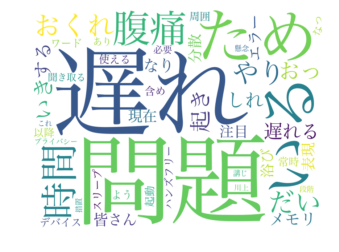

In [67]:
# Plot the result

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [68]:
wordcloud.to_file("./wordcloud_ai.png")

## [Task 3] What Kind of Person He/She is